In [ ]:
!pip install pytorch-lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.5 MB/s eta 0:00:00


In [ ]:
import os
import urllib.request
from copy import deepcopy
from urllib.error import HTTPError
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from IPython.display import set_matplotlib_formats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.callbacks import Callback

import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import torchvision.models as models
from tqdm.notebook import tqdm


from torch.optim import Adam

import numpy as np
from torch.optim.lr_scheduler import OneCycleLR

import zipfile
from PIL import Image
import cv2

In [ ]:
print(torch.__version__, torchvision.__version__, pl.__version__)

2.1.0+cu118 0.16.0+cu118 2.1.1


In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
NUM_WORKERS = os.cpu_count()
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cuda:0
Number of workers: 2


In [ ]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [ ]:
DATASET_PATH_train = os.environ.get("DATASET_PATH", "/content/drive/MyDrive/DR_data/split/train")
DATASET_PATH_val = os.environ.get("DATASET_PATH", "/content/drive/MyDrive/DR_data/split/val")
DATASET_PATH_test = os.environ.get("DATASET_PATH", "/content/drive/MyDrive/DR_data/split/test")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "/content/drive/MyDrive/Models")

In [ ]:
#@title Augmentations
class DataAugmentation:
    def __init__(self, image_size, n_views=2):
        self.image_size = image_size
        self.n_views = n_views

    def __call__(self, x):
        augmented_data = []
        for _ in range(self.n_views):
            augmented_image = self.transform(x)
            augmented_data.append(augmented_image)

        return augmented_data

    def transform(self, x):

        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=self.image_size),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=9),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
        x_transformed = transform(x)

        return x_transformed


In [ ]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform

        # Create an ImageFolder dataset for the root_dir
        self.dataset = ImageFolder(self.root_dir, transform=self.transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the image and its class label
        image, class_label = self.dataset[idx]

        return image, class_label

In [ ]:
data_augmentation = DataAugmentation(image_size=224, n_views=2)
test_aug = TestDataAugmentation(image_size=224)
train_data = CustomDataset(DATASET_PATH_train, transform=data_augmentation)
train_loader = DataLoader(train_data, batch_size=15, shuffle=True, num_workers=2, drop_last=True)
val_data = CustomDataset(DATASET_PATH_val, transform=data_augmentation)
val_loader = DataLoader(val_data, batch_size=15, shuffle=False, num_workers=2, drop_last=True)
# test_data = CustomDataset(DATASET_PATH_test, transform=test_aug)
# test_loader = DataLoader(test_data, batch_size=15, shuffle=False, num_workers=2, drop_last=True)

In [ ]:
from torchvision import transforms

# Use transform, not transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_data = CustomDataset(DATASET_PATH_test, transform=transform)  # Use transform, not transforms
test_loader = DataLoader(test_data, batch_size=15, shuffle=False, num_workers=2, drop_last=True)

In [ ]:
print("Train images:",len(train_data))
print("Val images:",len(val_data))
print("Test images:",len(test_data))
print("Total images:", len(train_data)+len(val_data)+len(test_data))

Train images: 2445
Val images: 700
Test images: 355
Total images: 3500


In [ ]:
total_images = 0
total_batches = 0

for batch in test_loader:
    batch_size = len(batch)  # Get the number of items (views) in the batch
    total_images += batch_size
    total_batches += 1
    print(f"Batch {total_batches}: {batch_size} views")

print(f"Total images in the DataLoader: {total_images}")
print(f"Total batches in the DataLoader: {total_batches}")

NameError: ignored

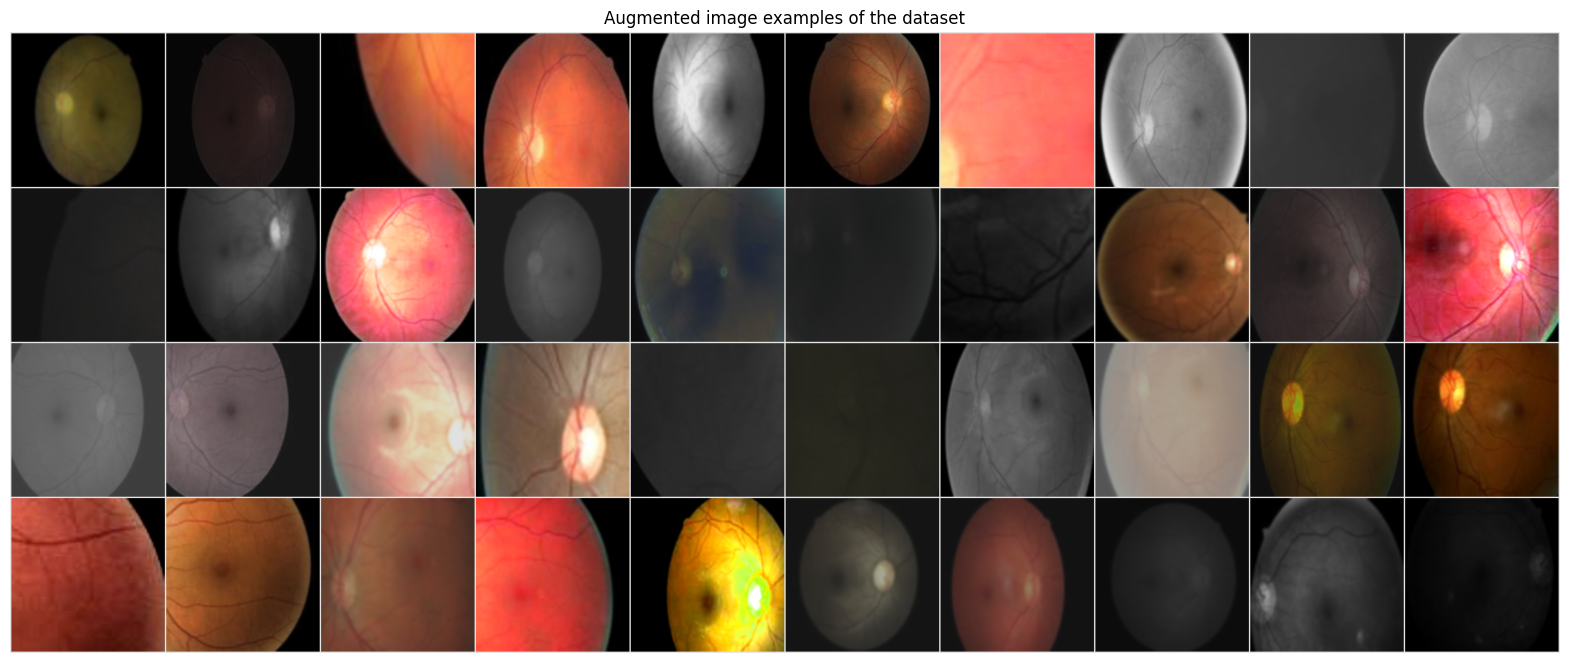

In [ ]:
#@title Visualize some examples
NUM_IMAGES = 20
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in train_data.dataset[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=10, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(20, 10))
plt.title("Augmented image examples of the dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
#plt.close()

In [ ]:
#@title Loss Function
class NTXentLoss(torch.nn.Module):

    def __init__(self, device, batch_size, temperature, use_cosine_similarity):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.softmax = torch.nn.Softmax(dim=-1)
        self.mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self.similarity_function = self._get_similarity_function(use_cosine_similarity)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum").cuda()

    def _get_similarity_function(self, use_cosine_similarity):
        if use_cosine_similarity:
            self._cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
            return self._cosine_simililarity
        else:
            return self._dot_simililarity

    def _get_correlated_mask(self):
        diag = np.eye(2 * self.batch_size)
        l1 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=-self.batch_size)
        l2 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=self.batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask.to(self.device)

    @staticmethod
    def _dot_simililarity(x, y):
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        return v

    def _cosine_simililarity(self, x, y):
        v = self._cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def forward(self, zis, zjs):
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self.similarity_function(representations, representations)
        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, self.batch_size)
        r_pos = torch.diag(similarity_matrix, -self.batch_size)
        # print("Shape of l_pos:", l_pos.size())
        # print("Shape of r_pos:", r_pos.size())
        positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)
        # print("Shape of positives:",  positives.size())
        positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)

        negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)

        logits = torch.cat((positives, negatives), dim=1)
        logits /= self.temperature

        labels = torch.zeros(2 * self.batch_size).to(self.device).long()
        loss = self.criterion(logits, labels)

        return loss / (2 * self.batch_size)

In [ ]:
#@title ResNetSimCLR
class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim, freeze=True):
        super(ResNetSimCLR, self).__init__()

        # Number of input features into the last linear layer
        num_ftrs = base_model.fc.in_features
        # Remove last layer of resnet
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        if freeze:
            self._freeze()

        # header projection MLP - for SimCLR
        self.l1 = nn.Linear(num_ftrs, 2*num_ftrs)
        self.l2_bn = nn.BatchNorm1d(2*num_ftrs)
        self.l2 = nn.Linear(2*num_ftrs, num_ftrs)
        self.l3_bn = nn.BatchNorm1d(num_ftrs)
        self.l3 = nn.Linear(num_ftrs, out_dim)

    def _freeze(self):
        num_layers = len(list(self.features.children())) # 9 layers, freeze all but last 2
        current_layer = 1
        for child in list(self.features.children()):
            if current_layer > num_layers-2:
                for param in child.parameters():
                    param.requires_grad = True
            else:
                for param in child.parameters():
                    param.requires_grad = False
            current_layer += 1

    def forward(self, x):
        h = self.features(x)
        h = h.squeeze()

        if len(h.shape) == 1:
            h = h.unsqueeze(0)

        x_l1 = self.l1(h)
        x = self.l2_bn(x_l1)
        x = F.selu(x)
        x = self.l2(x)
        x = self.l3_bn(x)
        x = F.selu(x)
        x = self.l3(x)
        return h, x_l1, x

In [ ]:
#@title Config
import yaml # Handles config file loading
# Load config file
config = '''
batch_size: 15
epochs: 9
weight_decay: 10e-6
out_dim: 256

dataset:
  s: 1
  input_shape: (224, 224, 3)
  num_workers: 2

optimizer:
  lr: 0.0001

loss:
  temperature: 0.05
  use_cosine_similarity: True

lr_schedule:
  max_lr: .1
  total_steps: 1500

model:
  out_dim: 128
  base_model: "resnet50"
'''
config = yaml.full_load(config)

In [ ]:
#@title simCLR
class simCLR(pl.LightningModule):

    def __init__(self, model, config, optimizer=Adam, loss=NTXentLoss):
        super(simCLR, self).__init__()
        # Config file (dictionary) to pass on parameters to each module: optimizer, loss, lr_schedule,
        self.config = config

        # Optimizer
        self.optimizer = optimizer

        # Model
        self.model = model

        # Loss
        self.loss = loss('cuda', self.config['batch_size'], **self.config['loss'])

    # Prediction/inference
    def forward(self, x):
        return self.model(x)

    # Sets up optimizer
    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), **self.config['optimizer'])
        scheduler = OneCycleLR(optimizer, **self.config["lr_schedule"])
        return [optimizer], [scheduler]

    # Training loops
    def training_step(self, batch, batch_idx):
        x, y = batch
        xis, xjs = x
        ris, _, zis = self(xis)
        rjs, _, zjs = self(xjs)

        zis = F.normalize(zis, dim=1)
        zjs = F.normalize(zjs, dim=1)
        # print("zis shape", zis.size())
        # print("zjs shape",zjs.size())


        loss = self.loss(zis, zjs)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    # Validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        xis, xjs = x
        ris, _, zis = self(xis)
        rjs, _, zjs = self(xjs)

        zis = F.normalize(zis, dim=1)
        zjs = F.normalize(zjs, dim=1)

        loss = self.loss(zis, zjs)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss = None
        return loss

def _get_model_checkpoint():
    return ModelCheckpoint(
        filepath=os.path.join(os.getcwd(),"checkpoints","best_val_models"),
        save_top_k = 3,
        monitor="val_loss"
    )

In [ ]:
resnet = models.resnet50(pretrained=True)

simclr_resnet = ResNetSimCLR(base_model=resnet, out_dim=config['out_dim'])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 64.2MB/s]


In [ ]:
# Creates the simCLR model with the specified architecture from aboce
model = simCLR(config=config, model=simclr_resnet)

In [ ]:
# Initializes the model trainer
trainer = pl.Trainer(accelerator="gpu",
                     default_root_dir="/content/drive/MyDrive",
                     max_epochs=9,
                     devices="auto",
                     log_every_n_steps=10)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Fits the model
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | ResNetSimCLR | 40.8 M
1 | loss  | NTXentLoss   | 0     
---------------------------------------
32.3 M    Trainable params
8.5 M     Non-trainable params
40.8 M    Total params
163.313   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.


In [ ]:
# saving the model
# torch.save(model.state_dict(), '/content/drive/MyDrive/Models/weights_only_Resnet50.pth')
torch.save(model, '/content/drive/MyDrive/Models/1_DR_atpos_balanced_Resnet50.pth')

In [ ]:
model = torch.load('/content/drive/MyDrive/Models/1_DR_atpos_balanced_Resnet50.pth')

In [ ]:
print(model)

simCLR(
  (model): ResNetSimCLR(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
       

In [ ]:
# Add a new linear layer for 5 classes
model.l4 = nn.Linear(256, 5)  # Assuming 256 features from the previous layer

In [ ]:
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        print("Input shape:", images.shape)

        # Assuming your model returns a tuple and you want the first output
        _, _,outputs  = model(images)

        # Print some model outputs for debugging
        print("Model outputs shape:", outputs.shape)

        # Use torch.max on the output tensor
        _, predicted = torch.max(outputs, 1)

        # Append the predicted labels and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Convert lists to numpy arrays for easier analysis
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Print some predictions and labels for debugging
print("/content/drive/MyDrive/Predictions:", all_preds)
print("/content/drive/MyDrive/Labels:", all_labels)

Input shape: torch.Size([15, 3, 224, 224])
Model outputs shape: torch.Size([15, 256])
Input shape: torch.Size([15, 3, 224, 224])
Model outputs shape: torch.Size([15, 256])
Input shape: torch.Size([15, 3, 224, 224])


KeyboardInterrupt: ignored

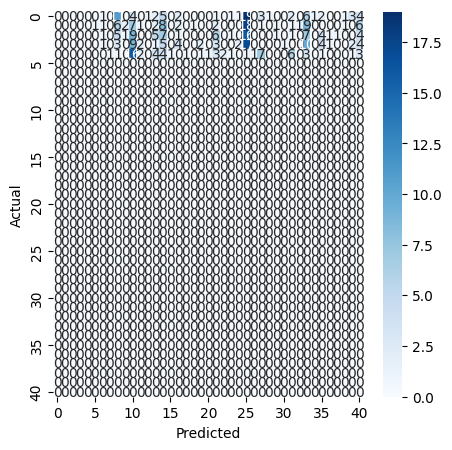

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=5, yticklabels=5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# import numpy as np

# Assuming your model is already loaded and modified for your new dataset
model.eval()

# Create lists to store predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Forward pass
        _, _, outputs = model(images)

        # Convert predictions and labels to numpy arrays
        preds_array = outputs.cpu().numpy()
        labels_array = labels.cpu().numpy()

        # Append to the lists
        all_preds.append(preds_array)
        all_labels.append(labels_array)

# Concatenate the lists to create numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Save the numpy arrays to a file
np.save('/content/drive/MyDrive/predictions.npy', all_preds)
np.save('/content/drive/MyDrive/labels.npy', all_labels)